In [12]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 50 #higher precision
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from plotDensity import *

# filenameI_12 =  '../results/open/prob_0.100000/X_12_Y_12/seed_42/error_class_I/intervals_20_iterations_10000_overlap_0.250000_walkers_8_seed_run_42_alpha_0.800000_beta_0.0000000100.txt'
# filenameX_12 =  '../results/open/prob_0.100000/X_12_Y_12/seed_42/error_class_X/intervals_20_iterations_10000_overlap_0.250000_walkers_8_seed_run_42_alpha_0.800000_beta_0.0000000100.txt'

filenameI_10 =  '../results/open/prob_0.100000/X_10_Y_10/seed_44/error_class_I/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_44_alpha_0.800000_beta_0.0001000000.txt'
filenameX_10 =  '../results/open/prob_0.100000/X_10_Y_10/seed_44/error_class_X/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_44_alpha_0.800000_beta_0.0001000000.txt'

filenameI_10_2 =  '../results/open/prob_0.100000/X_10_Y_10/seed_43/error_class_I/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_43_alpha_0.800000_beta_0.0001000000.txt'
filenameX_10_2 =  '../results/open/prob_0.100000/X_10_Y_10/seed_43/error_class_X/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_43_alpha_0.800000_beta_0.0001000000.txt'

filenameI_12 =  '../results/open/prob_0.100000/X_12_Y_12/seed_44/error_class_I/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_44_alpha_0.800000_beta_0.0001000000.txt'
filenameX_12 =  '../results/open/prob_0.100000/X_12_Y_12/seed_44/error_class_X/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_44_alpha_0.800000_beta_0.0001000000.txt'

filenameI_12_2 =  '../results/open/prob_0.100000/X_12_Y_12/seed_43/error_class_I/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_43_alpha_0.800000_beta_0.0001000000.txt'
filenameX_12_2 =  '../results/open/prob_0.100000/X_12_Y_12/seed_43/error_class_X/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_43_alpha_0.800000_beta_0.0001000000.txt'


results = [read_data_from_file(filenameI_10),read_data_from_file(filenameX_10),\
           read_data_from_file(filenameI_10_2),read_data_from_file(filenameX_10_2),\
           read_data_from_file(filenameI_12),read_data_from_file(filenameX_12),\
           read_data_from_file(filenameI_12_2),read_data_from_file(filenameX_12_2)]

Xlist = [10,10,10,10,12,12,12,12]
Ylist = [10,10,10,10,12,12,12,12]

In [13]:
rescaled_results = []
for result_index,result in enumerate(results): 
    
    X = Xlist[result_index]
    Y = Ylist[result_index]
    

    walker_results = result

    """normalize the walker results by min value for log results"""
    walker_results = get_renormalized_log_g_values_as_dict_list(walker_results)

    """averages over walker results per intervals"""
    walker_results = average_matching_keys(walker_results)

    results_x = []
    results_y = []
    for result in walker_results:
        results_y.append(np.array(list(result.values())))
        results_x.append(np.array(list(result.keys())))

    """get inverse temp by log(g) derivative"""
    derivatives_wrt_e = get_derivative_wrt_e(walker_results)

    """get energy per interval pair with lowest deviation of inverse temp"""
    minimum_deviation_energies = find_lowest_inverse_temp_deviation(derivatives_wrt_e)

    """rescaling of log(g) values at concatenation points"""
    rescale_results_for_concatenation(results_x, results_y, minimum_deviation_energies)


    x_max = -1 -2*X*Y
    rescaled_x = []
    rescaled_y = []
    for i in range(len(results_x)):
        for j in range(len(results_x[i])):
            if results_x[i][j] > x_max: #avoid double counting
                x_max = results_x[i][j]
                rescaled_x.append(results_x[i][j])
                rescaled_y.append(results_y[i][j])
    
    rescaled_results.append([rescaled_x,rescaled_y])

[-114 -112 -110 -108 -106 -104 -102 -100  -98  -96  -94  -92  -90  -88
  -86  -84  -82  -80  -78  -76  -74  -72  -70  -68  -66  -64]
[-110 -108 -106 -104 -102 -100  -98  -96  -94  -92  -90  -88  -86  -84
  -82  -80  -78  -76  -74  -72  -70  -68  -66  -64  -62  -60]
[-104 -102 -100  -98  -96  -94  -92  -90  -88  -86  -84  -82  -80  -78
  -76  -74  -72  -70  -68  -66  -64  -62  -60  -58]
[-108 -106 -104 -102 -100  -98  -96  -94  -92  -90  -88  -86  -84  -82
  -80  -78  -76  -74  -72  -70  -68  -66  -64  -62  -60]
[-166 -164 -162 -160 -158 -156 -154 -152 -150 -148 -146 -144 -142 -140
 -138 -136 -134 -132 -130 -128 -126 -124 -122 -120 -118 -116 -114 -112
 -110 -108 -106 -104 -102 -100  -98  -96  -94  -92  -90]
[-162 -160 -158 -156 -154 -152 -150 -148 -146 -144 -142 -140 -138 -136
 -134 -132 -130 -128 -126 -124 -122 -120 -118 -116 -114 -112 -110 -108
 -106 -104 -102 -100  -98  -96  -94  -92  -90  -88]
[-156 -154 -152 -150 -148 -146 -144 -142 -140 -138 -136 -134 -132 -130
 -128 -126 -124 -12

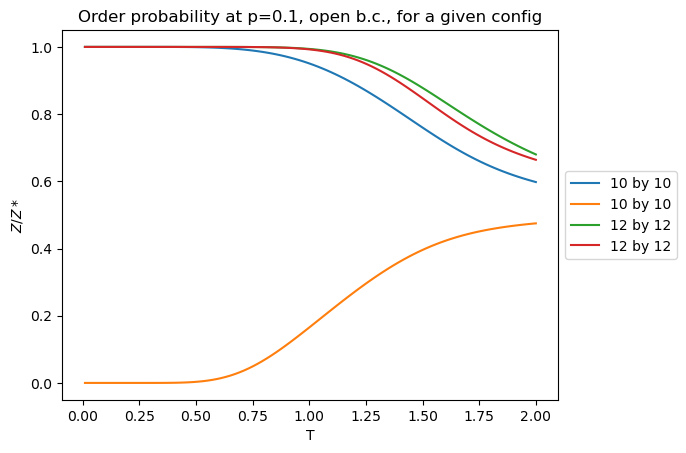

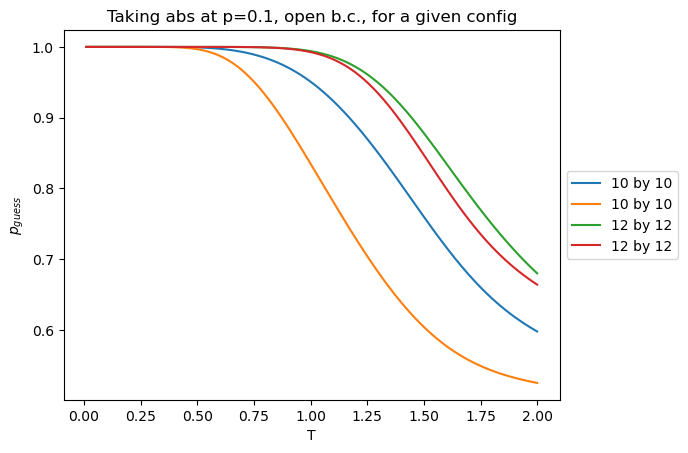

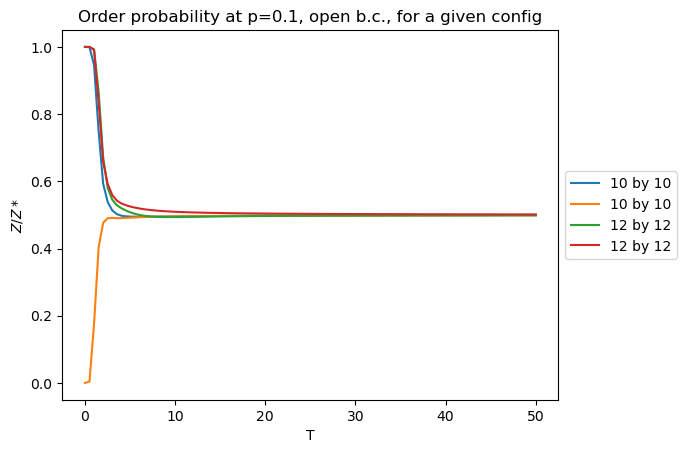

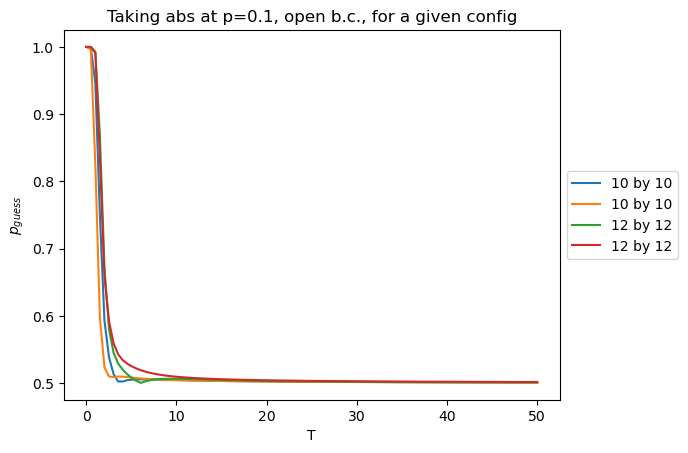

In [15]:
def free_energy(E_list, log_g_list,  T):
    #Need to log sum over g(E)*exp(-E/T) without overflow issues   
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Infinite temperature version, for scaling
def free_energy_infinity(E_list, log_g_list):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res



for i in range(len(rescaled_results)):
    
    X = Xlist[i]
    Y = Ylist[i]
    
    offset = free_energy_infinity(rescaled_results[i][0], rescaled_results[i][1])
    rescaled_results[i][1] = [res + mp.log(2)*X*Y - offset for res in rescaled_results[i][1]]
    
    
#     print('High temperature')
#     T = 1e100
#     print(free_energy(rescaled_results[i][0], rescaled_results[i][1], T)/(-T))
#     print('Expected at infinite T:',mp.log(2)*X*Y)
#     T = 1e-100
#     print('Low temperature (should correspond to lowest energy in range)')
#     print(free_energy(rescaled_results[i][0], rescaled_results[i][1], T))


#     if i%2 ==0:
#         plt.figure()
#         plt.plot(rescaled_results[0][0], rescaled_results[0][1],label="I")
#     else:
#         plt.plot(rescaled_results[1][0], rescaled_results[1][1],label="X")
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         plt.title('log g for X=%d'%X+', Y=%d'%Y)
#         plt.show()



for max_temp in [2,50]:

    temperatures = np.linspace(0.01,max_temp,100)
    free_energies = []
    for i in range(len(rescaled_results)):
        f_values = []
        for T in temperatures:
            f_values.append(free_energy(rescaled_results[i][0], rescaled_results[i][1], T)/(-T))
        free_energies.append(f_values)
    
    plt.figure() 
    for i in range(len(rescaled_results)//2):
        i *= 2
        X = Xlist[i]
        Y = Ylist[i]
        plt.plot(temperatures, [1/(1+ mp.exp(free_energies[i+1][j] - free_energies[i][j])) \
                                for j in range(len(free_energies[i]))],label="%d"%X+" by %d"%Y)
        
    plt.title("Order probability at p=0.1, open b.c., for a given config")
    plt.ylabel(r"$Z/Z*$")
    plt.xlabel("T")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
    
    plt.figure() 
    for i in range(len(rescaled_results)//2):
        i *= 2
        X = Xlist[i]
        Y = Ylist[i]
        plt.plot(temperatures, [1/(1+ mp.exp(-abs(free_energies[i+1][j] - free_energies[i][j]))) \
                                for j in range(len(free_energies[i]))],label="%d"%X+" by %d"%Y)
    
    plt.title("Taking abs at p=0.1, open b.c., for a given config")
    plt.ylabel(r"$p_{guess}$")
    plt.xlabel("T")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    